# QLDPC decoder

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import galois

In [2]:
GF = galois.GF(2)

In [3]:
def tanner_graph(H: np.ndarray):
    "Create tanner graph from a parity check matrix H."
    m, n = H.shape
    T = nx.Graph()

    T.H = H
    # nodes
    T.VD = [i for i in range(n)]
    T.VC = [-j-1 for j in range(m)]

    # add them, with positions
    for i, node in enumerate(T.VD):
        T.add_node(node, pos=(i-n/2, 0), label='$d_{'+str(i)+'}$')
    for j, node in enumerate(T.VC):
        T.add_node(node, pos=(j-m/2, 1), label='$c_{'+str(j)+'}$')

    # add checks to graph
    for j, check in enumerate(H):
        for i, v in enumerate(check):
            if v:
                T.add_edge(-j-1, i)

    return T

def draw_tanner_graph(T, highlight_vertices=None):
    plt.figure(figsize=(40,30))
    "Draw the graph. highlight_vertices is a list of vertices to be colored."
    pl=nx.get_node_attributes(T,'pos')
    lbls = nx.get_node_attributes(T, 'label')

    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VD, node_shape='o')
    nx.draw_networkx_nodes(T, pos=pl, nodelist=T.VC, node_shape='s')
    nx.draw_networkx_labels(T, pos=pl, labels=lbls)

    nx.draw_networkx_edges(T, pos=pl)

    if highlight_vertices:
        nx.draw_networkx_nodes(T,
                               pos=pl,
                               nodelist=[int(v[:]) for v in highlight_vertices if v[0] == 'd'],
                               node_color='red',
                               node_shape='o')
        nx.draw_networkx_nodes(T,
                       pos=pl,
                       nodelist=[-int(v[:])-1 for v in highlight_vertices if v[0] == 'c'],
                       node_color='red',
                       node_shape='s')

    plt.axis('off');

# these four functions allow us to convert between 
# (s)tring names of vertices and (i)nteger names of vertices
def s2i(node):
    return int(node[1]) if node[0] == 'd' else -int(node[1])-1

def i2s(node):
    return f'd{node}' if node>=0 else f'c{-node-1}'

def ms2i(W: set):
    return set(map(s2i, W))

def mi2s(W: set):
    return set(map(i2s, W))

In [4]:
def interior(T, W):
    "Determine interior of vertex subset W of Tanner graph T."
    IntW = set()
    for v in W:
        if set(nx.neighbors(T,v)).issubset(W):
            IntW.add(v)
    return IntW


def solvable_system(A,b):
    "Determines if there is a solution to Ax=b."
    A_rank = np.linalg.matrix_rank(A)

    # create augmented matrix
    Ab = np.hstack((A, np.atleast_2d(b).T))

    # Must be true for solutions to be consistent
    return A_rank == np.linalg.matrix_rank(Ab)

def solve_underdetermined_system(A, b):
    "Returns a random solution to Ax=b."
    n_vars = A.shape[1]
    A_rank = np.linalg.matrix_rank(A)

    # create augmented matrix
    Ab = np.hstack((A, np.atleast_2d(b).T))

    # Must be true for solutions to be consistent
    if A_rank != np.linalg.matrix_rank(Ab):
        raise Exception("No solution exists.")

    # reduce the system
    Abrr = Ab.row_reduce()

    # additionally need form in which the identity
    # is moved all the way to the left. Do some
    # column swaps to achieve this.
    swaps = []
    for i in range(min(Abrr.shape)):
        if Abrr[i,i] == 0:
            for j in range(i+1,n_vars):
                if Abrr[i,j] == 1:
                    Abrr[:, [i,j]] = Abrr[:, [j,i]]
                    swaps.append((i,j))
                    break

    # randomly generate some independent variables
    n_ind = n_vars - A_rank
    ind_vars = GF(np.zeros(n_ind,dtype = int))

    # compute dependent variables using reduced system and dep vars
    dep_vars = -Abrr[:A_rank,A_rank:n_vars]@ind_vars + Abrr[:A_rank,-1]

    # x is just concatenation of the two
    x = np.hstack((dep_vars, ind_vars))

    # swap the entries of x according to the column swaps earlier
    # to get the solution to the original system.
    for s in reversed(swaps):
        x[s[0]], x[s[1]] = x[s[1]], x[s[0]]

    return x


def is_valid_cluster(T, syndrome, cluster):
    "Given a syndrome and cluster, determines if is is valid."

    cluster_interior = interior(T, cluster)

    data_qubits_in_interior = sorted([i for i in cluster_interior if i>=0])
    check_qubits_in_cluster = sorted([-i-1 for i in cluster if i<0])

    GF = galois.GF(2)
    A = GF(T.H[check_qubits_in_cluster][:,data_qubits_in_interior])
    b = GF([syndrome[i] for i in check_qubits_in_cluster])

    solved = solvable_system(A,b)

    return solved


def find_valid_correction(T, syndrome, cluster):

    cluster_interior = interior(T, cluster)

    data_qubits_in_interior = sorted([i for i in cluster_interior if i>=0])
    check_qubits_in_cluster = sorted([-i-1 for i in cluster if i<0])

    GF = galois.GF(2)
    A = GF(T.H[check_qubits_in_cluster][:,data_qubits_in_interior])
    b = GF([syndrome[i] for i in check_qubits_in_cluster]) 

    sol = solve_underdetermined_system(A,b)

    return sol, data_qubits_in_interior

def cluster_neighbors(T, cluster):
    nbrs = set()
    for v in cluster:
        nbrs.update(set(nx.neighbors(T,v)))
    return nbrs

# Now the actual decoder

use the respository from https://github.com/quantumgizmos/bias_tailored_qldpc/tree/main

In [5]:
def my_ldpc_decoder(T, syndrome):

    n = len(T.VD)

    # assign each syndrome to its own cluster
    K = [set([-i-1]) for i,s in enumerate(syndrome) if s]

    valid_clusters = lambda K : np.array([is_valid_cluster(T, syndrome, Ki) for Ki in K]).all()
    n_finite_loop = 0
    # grow clusters till all are valid
    while True:
        # if during the loop below some clusters are
        # merged, then we restart the loop
        K_updated = False
        n_finite_loop+=1
        # When clusters are merged, then later need to
        # delete the one that was added to the other.
        to_delete = set()
        #print(f"Restarting {K}")
        for i, Ki in enumerate(K):
            # print(f'K{i} = {Ki}')
            if not is_valid_cluster(T, syndrome, Ki):
                nbrs = cluster_neighbors(T, Ki)
                Ki.update(nbrs)
                # print(f'K{i} with nbrs = {Ki}')
                # for loop to check if clusters need to
                # be merged with this newly grown one
                for j, Kj in enumerate(K):
                    if j < i and (not nbrs.isdisjoint(Kj)) and (not is_valid_cluster(T, syndrome, Kj)):
                        Kj.update(Ki)
                        # print(f'K{j} with K{i} = {Kj}')
                        to_delete.update([i])
                        K_updated = True
                    elif j > i and (not nbrs.isdisjoint(Kj)) and (not is_valid_cluster(T, syndrome, Kj)):
                        Ki.update(Kj)
                        # print(f'K{i} with K{j} = {Ki}')
                        to_delete.update([j])
                        K_updated = True
                if K_updated:
                    break
        for i in reversed(sorted(to_delete)):
            K.pop(i)
        if valid_clusters(K):
            break
        if n_finite_loop>100:
            print('loop failed to terminate')
            break

    # determine error estimate using valid clusters
    e_estimate = np.array([0]*n, dtype=int)
    for i, Ki in enumerate(K):
        correction, correction_data_qubits = find_valid_correction(T, syndrome, Ki)
        e_estimate[correction_data_qubits] = correction

    return e_estimate, K 

In [7]:
from bposd.hgp import hgp
import time
from numpy.random import randint

In [8]:
HL = np.array([[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0],
            [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
            [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
            [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]])
qcode=hgp(HL,HL,compute_distance=True)
qcode.test()
Hx = qcode.hx
Tx = tanner_graph(Hx)

<Unnamed CSS code>, (4,7)-[[400,16,6]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (4,7)-[[400,16,6]]


In [10]:
runs = 1000
n_incorrect = 0
n_decode = 0
p =.001
for i in range(runs):

    x_error = np.array([0]*qcode.N, dtype =int)
    for j in range(qcode.N):
        if np.random.random(1)<p:
            x_error[j] = 1

    syndrome = Hx@x_error %2
    e_estimate, final_clusters = my_ldpc_decoder(Tx, syndrome)

    if (Hx@(x_error - e_estimate)%2).all():
        n_decode+=1
        print(f'not a correction')

    for n, L in enumerate(qcode.lz):
        if (x_error-e_estimate) @ L %2 != 0:
            n_incorrect +=1
            break
    
    if i % int(runs/5) ==0:
        print(f'there are {len(final_clusters)} clusters')
        print(f'{n_incorrect} wrong after run {i}')

print(f'Fraction incorrect {n_incorrect/runs:0.3f}')
print(f'failed to decode {n_decode/runs}')


there are 0 clusters
0 wrong after run 0
there are 1 clusters
0 wrong after run 100
there are 2 clusters
0 wrong after run 200
there are 1 clusters
0 wrong after run 300
there are 1 clusters
2 wrong after run 400
there are 0 clusters
2 wrong after run 500
there are 1 clusters
2 wrong after run 600
there are 0 clusters
2 wrong after run 700
there are 0 clusters
5 wrong after run 800
there are 0 clusters
6 wrong after run 900
Fraction incorrect 0.006
failed to decode 0.0


# Now let's do some monte carlo to test decoder at different error rates

In [27]:
p_list = [0,.001, .003, .005, .008, .01, .015, .02]

In [29]:
import time
t0 = time.time()

runs = 10**3
threshold_data = []

for p in p_list:
    n_incorrect = 0
    for i in range(runs):

        x_error = np.array([0]*qcode.N, dtype =int)
        for j in range(qcode.N):
            if np.random.random(1)<p:
                x_error[j] = 1

        syndrome = Hx@x_error %2
        e_estimate, final_clusters = my_ldpc_decoder(Tx, syndrome)

        for n, L in enumerate(qcode.lz):
            if (x_error-e_estimate) @ L %2 != 0:
                n_incorrect +=1
                break
        
        if i % int(runs/2) ==0:
            print(f'there are {len(final_clusters)} clusters')
            print(f'{n_incorrect} wrong after run {i}')
            print(f'run {i} for p = {p} at time {time.time()-t0}')
            print('==============================================')

    threshold_data.append(n_incorrect/runs)
    
    print(f'Fraction incorrect {n_incorrect/runs:0.3f}')
    print(f'failed to decode {n_decode/runs}')

there are 0 clusters
0 wrong after run 0
run 0 for p = 0 at time 0.0023412704467773438
there are 0 clusters
0 wrong after run 500
run 500 for p = 0 at time 0.23891615867614746
Fraction incorrect 0.000
failed to decode 0.0
there are 1 clusters
0 wrong after run 0
run 0 for p = 0.001 at time 0.4678459167480469
there are 2 clusters
2 wrong after run 500
run 500 for p = 0.001 at time 1.91090726852417
Fraction incorrect 0.005
failed to decode 0.0
there are 2 clusters
0 wrong after run 0
run 0 for p = 0.003 at time 3.5352840423583984
there are 1 clusters
38 wrong after run 500
run 500 for p = 0.003 at time 12.30827283859253
Fraction incorrect 0.065
failed to decode 0.0
there are 1 clusters
0 wrong after run 0
run 0 for p = 0.005 at time 19.755333185195923
there are 3 clusters
66 wrong after run 500
run 500 for p = 0.005 at time 35.54556107521057
Fraction incorrect 0.149
failed to decode 0.0
there are 1 clusters
1 wrong after run 0
run 0 for p = 0.008 at time 52.44486713409424
there are 1 clu

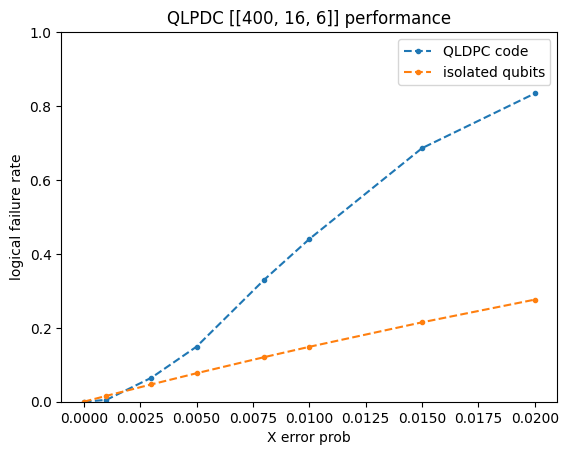

In [30]:
plt.plot(p_list, threshold_data, '--.', label = 'QLDPC code')
plt.plot(np.array(p_list) , np.ones(len(p_list))-(np.ones(len(p_list))-np.array(p_list))**16, '--.', label = 'isolated qubits')
plt.title(f'QLPDC {[[qcode.N, len(qcode.lz), qcode.D]]} performance')
plt.ylim(0,1)
plt.ylabel('logical failure rate')
plt.xlabel('X error prob')
plt.legend()
plt.show()

In [32]:
400/8

50.0